# Análise de microdados ENADE 2021

A seguir, apresentamos uma análise dos dados obtidos no Exame Nacional de Desempenho de Estudantes (ENADE) de 2021, com ênfase no número de inscritos e nas notas gerais dos cursos avaliados. Além disso, realizamos uma análise fatorial para identificar e compreender os fatores relacionados à percepção dos alunos em relação às condições do processo formativo. Posteriormente, utilizando a técnica de *Random Forest* examinamos como as características específicas dos cursos e a percepção dos alunos se inter-relacionam e influenciam o desempenho acadêmico.

In [18]:
# Pacotes manipulação e visualização
import math
import pandas as pd
import pickle
from tabulate import tabulate
from matplotlib import pyplot as plt

# Pacotes para rodar modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.features import FeatureImportances

In [19]:
dados_arq4 = data2 = pd.read_csv("./microdados/microdados2021_arq4.txt",
                         encoding ="latin1",
                         header = 0 ,
                         delimiter = ";").replace(7,3.5).replace(8,None)

In [20]:
with open('./microdados/microdados2021_arq4.pickle', 'wb') as handle:
    pickle.dump(data2, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Características do curso

A continuação juntamos os microdados **arq1** e **arq3**, referentes as características dos cursos.

Estes dados são utilizados para a construção do Dashboard.



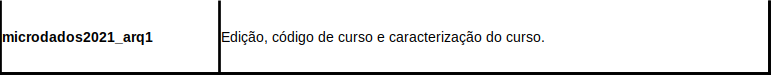


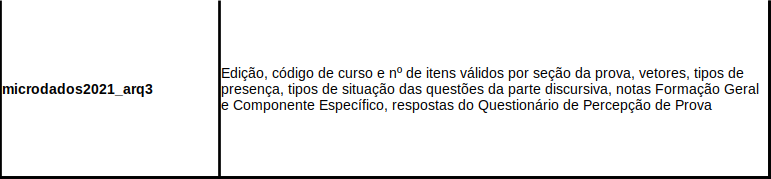

In [21]:
# Manipulação dos dados
with open('./microdados/microdados2021_arq1.pickle', 'rb') as handle:
    v = data = pickle.load(handle)

with open('./microdados/microdados2021_arq3.pickle', 'rb') as handle:
    v2 = data2 = pickle.load(handle)

v = v.merge(v2, on=['CO_CURSO'], how='left')

v['CO_ORGACAD'] = data['CO_ORGACAD'] = data['CO_ORGACAD'].replace(10019,10026)


x1 =data2.groupby(['CO_CURSO','TP_PRES']).size().reset_index(
    name='Total_Participantes').query("TP_PRES== 555 | TP_PRES== 556").groupby(
        ['CO_CURSO']).agg({'Total_Participantes': 'sum'}).reset_index()
x2 =data2.groupby(['CO_CURSO','TP_PRES']).size().reset_index(
    name='Total_Resultados_validos').query("TP_PRES== 555").groupby(
        ['CO_CURSO']).agg({'Total_Resultados_validos': 'sum'}).reset_index()
x3 =data2.groupby(['CO_CURSO',"TP_PRES"]).agg(
    {'NT_GER': 'mean'}).reset_index().query("TP_PRES== 555")

data2 = x1.merge(x2, on=['CO_CURSO'], how='left')
data2 = data2.merge(x3, on=['CO_CURSO'], how='left')

v1 = v.query("TP_PRES == 555").groupby(['CO_GRUPO','CO_CATEGAD']).agg(
    NT_GER_CATEGAD= ("NT_GER","mean")).reset_index()
v2 = v.query("TP_PRES == 555").groupby(['CO_GRUPO','CO_ORGACAD']).agg(
    NT_GER_ORGACAD= ("NT_GER","mean")).reset_index()
v3 = v.query("TP_PRES == 555").groupby(['CO_GRUPO','CO_REGIAO_CURSO']).agg(
    NT_GER_REGIAO= ("NT_GER","mean")).reset_index()


data=data.merge(v1, on=['CO_GRUPO','CO_CATEGAD'], how='left')
data=data.merge(v2, on=['CO_GRUPO','CO_ORGACAD'], how='left')
data=data.merge(v3, on=['CO_GRUPO','CO_REGIAO_CURSO'], how='left')


data=data.merge(data2, on=['CO_CURSO'], how='left')
data = data.assign(CO_CATEGAD = lambda x: x["CO_CATEGAD"].apply(
    lambda y: "Federal" if  y == 1 else
 ("Estadual" if y == 2 else
  ("Municipal" if y == 3 else
   ("Privada com fins lucrativos" if y == 4 else
    ("Privada sem fins lucrativos" if y == 5 else "Especial"))))))



data = data.assign(CO_ORGACAD = lambda x: x["CO_ORGACAD"].apply(
    lambda y: "Centro Universitário" if  y == 10020 else ("Faculdade" if y == 10022 else ("IF/CEFET" if y == 10026 else 'Universidade'))))

data = data.assign(
    CO_REGIAO_CURSO = lambda x: x["CO_REGIAO_CURSO"].apply(
        lambda y: "Norte" if  y == 1 else ("Nordeste" if y == 2 else ("Sudeste" if y == 3 else("Sul" if y == 4 else "Centro-Oeste")))))

grupos = {
    26: "Design",
    72: "Tecnologia em Análise e Desenvolvimento de Sistemas",
    79: "Tecnologia em Redes de Computadores",
    702: "Matemática (Licenciatura)",
    904: "Letras-Português (Licenciatura)",
    905: "Letras-Português e Inglês (Licenciatura)",
    906: "Letras-Português e Espanhol (Licenciatura)",
    1402: "Física (Licenciatura)",
    1501: "Química (Bacharelado)",
    1502: "Química (Licenciatura)",
    1601: "Ciências Biológicas (Bacharelado)",
    1602: "Ciências Biológicas (Licenciatura)",
    2001: "Pedagogia (Licenciatura)",
    2401: "História (Bacharelado)",
    2402: "História (Licenciatura)",
    2501: "Artes Visuais (Licenciatura)",
    3001: "Geografia (Bacharelado)",
    3002: "Geografia (Licenciatura)",
    3201: "Filosofia (Bacharelado)",
    3202: "Filosofia (Licenciatura)",
    3501: "Educação Física (Bacharelado)",
    3502: "Educação Física (Licenciatura)",
    4004: "Ciência Da Computação (Bacharelado)",
    4005: "Ciência Da Computação (Licenciatura)",
    4006: "Sistemas de Informação",
    4301: "Música (Licenciatura)",
    5401: "Ciências Sociais (Bacharelado)",
    5402: "Ciências Sociais (Licenciatura)",
    6407: "Letras-Inglês (Licenciatura)",
    6409: "Tecnologia em Gestão da Tecnologia da Informação"
}

# Aplicar replace
data['CO_GRUPO'] = data['CO_GRUPO'].replace(grupos)
data.head(5)

,NU_ANO,CO_CURSO,CO_IES,CO_CATEGAD,CO_ORGACAD,CO_GRUPO,CO_MODALIDADE,CO_MUNIC_CURSO,CO_UF_CURSO,CO_REGIAO_CURSO,Total_Inscritos,NT_GER_CATEGAD,NT_GER_ORGACAD,NT_GER_REGIAO,Total_Participantes,Total_Resultados_validos,TP_PRES,NT_GER
0,2021,6,1,Federal,Universidade,Pedagogia (Licenciatura),1,5103403,51,Centro-Oeste,18,44.916882,48.573505,34.600995,7.0,7.0,555.0,58.542857
1,2021,19,1,Federal,Universidade,Educação Física (Licenciatura),1,5103403,51,Centro-Oeste,34,44.177003,45.328522,35.950206,21.0,21.0,555.0,39.933333
2,2021,23,25352,Federal,Universidade,Pedagogia (Licenciatura),1,5107602,51,Centro-Oeste,25,44.916882,48.573505,34.600995,22.0,22.0,555.0,45.113636
3,2021,24,25352,Federal,Universidade,Geografia (Licenciatura),1,5107602,51,Centro-Oeste,18,43.949945,44.379866,39.122407,15.0,15.0,555.0,41.753333
4,2021,25,25352,Federal,Universidade,História (Licenciatura),1,5107602,51,Centro-Oeste,30,50.762938,48.949618,42.270309,21.0,21.0,555.0,44.038095


In [22]:
nt_ger_stats = data['NT_GER'].describe()

total_inscritos_stats = data['Total_Inscritos'].describe()

stats_df = pd.DataFrame({
    'Variável': ['Nota Geral', 'Total Inscritos'],
    'Média': [nt_ger_stats['mean'], total_inscritos_stats['mean']],
    'Desvio Padrão': [nt_ger_stats['std'], total_inscritos_stats['std']],
    'Q.1.': [nt_ger_stats['25%'], total_inscritos_stats['25%']],
    'Mediana': [nt_ger_stats['50%'], total_inscritos_stats['50%']],
    'Q.3.': [nt_ger_stats['75%'], total_inscritos_stats['75%']]
})

table = tabulate(stats_df, headers='keys', tablefmt='fancy_grid', showindex=False)
print(table)

╒═════════════════╤═════════╤═════════════════╤═════════╤═══════════╤═════════╕
│ Variável        │   Média │   Desvio Padrão │    Q.1. │   Mediana │    Q.3. │
╞═════════════════╪═════════╪═════════════════╪═════════╪═══════════╪═════════╡
│ Nota Geral      │ 39.6577 │         8.34861 │ 33.8013 │   39.0429 │ 45.0079 │
├─────────────────┼─────────┼─────────────────┼─────────┼───────────┼─────────┤
│ Total Inscritos │ 61.2562 │       461.263   │ 12      │   24      │ 45      │
╘═════════════════╧═════════╧═════════════════╧═════════╧═══════════╧═════════╛


Em geral, as notas são relativamente baixas e não parece existir uma varição muito grande.

Em relação ao total de inscritos podemos notar uma grande variação que naturalmente ocorre por conta da diferença na densidade populacional entre as diferentes regiões do país.

### Análises a partir do Dashboard

Ao comparar as médias das notas gerais entre cursos presenciais (CO_MODALIDADE=1) e cursos EAD (CO_MODALIDADE=0), observamos que os cursos presenciais têm uma média de 50.7, enquanto os cursos EAD têm uma média de 41.8. Isso sugere que, em média, os cursos presenciais possuem notas gerais mais altas do que os cursos na modalidade EAD.

Ao verificar a dispersão das notas gerais, notamos que alguns cursos apresentam maior variação na qualidade dos cursos em ambos os grupos. Os cursos com maior variabilidade são Química (Licenciatura), Música (Licenciatura) e Tecnologia em Gestão da Tecnologia da Informação. Por outro lado, os cursos com menor variabilidade de notas são Química (Bacharelado) na modalidade EAD, Tecnologia em Análise e Desenvolvimento de Sistemas e Letras-Inglês (Licenciatura).

Entre os cursos com notas mais baixas, temos Química (Bacharelado) e Tecnologia em Análise e Desenvolvimento de Sistemas. Já entre os cursos com notas mais altas, destacam-se Música (Licenciatura), Educação Física (Licenciatura) e Letras-Inglês (Licenciatura).

A análise das notas médias por região revelou algumas tendências interessantes. Na região Centro-Oeste, o curso de "Design" destacou-se com a maior nota média, enquanto o curso de "Tecnologia em Análise e Desenvolvimento de Sistemas" teve a menor nota média na região. No Nordeste, o curso de "Filosofia (Bacharelado)" obteve a maior média, ao passo que "Tecnologia em Análise e Desenvolvimento de Sistemas" teve a menor média. Já na região Norte, o curso de "Filosofia (Bacharelado)" também liderou com a maior média, enquanto "Tecnologia em Análise e Desenvolvimento de Sistemas" apresentou a menor média.

No Sudeste, o curso de "História (Bacharelado)" alcançou a maior média, contrastando com "Tecnologia em Análise e Desenvolvimento de Sistemas", que teve a menor média. Por fim, na região Sul, "História (Bacharelado)" conquistou a maior média, e "Tecnologia em Análise e Desenvolvimento de Sistemas" obteve a menor média. Esses dados indicam possíveis discrepâncias na qualidade do ensino entre diferentes cursos nas regiões do Brasil.

A nível nacional, "Ciência da Computação (Bacharelado)" apresentou a maior variação nas notas, enquanto "Química (Bacharelado)" teve a menor variação. Nas diferentes regiões, cursos como "Design" no Centro-Oeste, "Tecnologia em Gestão da Tecnologia da Informação" no Nordeste e Norte, "História (Bacharelado)" no Sudeste, e novamente "História (Bacharelado)" no Sul, demonstraram maiores variações nas notas.

Por outro lado, cursos como "Física (Licenciatura)" no Centro-Oeste, "Tecnologia em Redes de Computadores" no Nordeste e Norte, e "Tecnologia em Redes de Computadores" no Sudeste e Sul exibiram menores variações nas notas. Esses resultados podem indicar a consistência do desempenho acadêmico em determinados cursos e a maior heterogeneidade em outros. É importante considerar que outros fatores podem influenciar as diferenças observadas, como a estrutura dos cursos e a diversidade de instituições de ensino presentes em cada região.

Cursos da área de Engenharia e Arquitetura, como "Engenharia de Computação" e "Arquitetura e Urbanismo", obtiveram ótimos desempenhos. Esses cursos foram predominantemente oferecidos por instituições federais e se destacaram por suas médias de aproximadamente 51.23 e 50.28, respectivamente. Por outro lado, cursos da área de Educação e Humanidades, como "Pedagogia" e "Filosofia" oferecidos por instituições privadas com fins lucrativos, apresentaram as menores notas médias, com médias de aproximadamente 38.13 e 35.99, respectivamente.

Quanto à variação nas notas, identificaram-se cursos com diferentes graus de dispersão dos resultados. Os cursos de "Arquitetura e Urbanismo" e "Direito", oferecidos por instituições federais e privadas sem fins lucrativos, respectivamente, apresentaram a menor variação nas notas, com desvio padrão de aproximadamente 2.54 e 2.86, respectivamente. Já os cursos de "Ciências Biológicas" e "Letras", oferecidos por instituições privadas sem fins lucrativos e federais, respectivamente, exibiram a maior variação, com desvio padrão de aproximadamente 12.74 e 9.91, respectivamente. Esses resultados destacam que os cursos das áreas de Engenharia e Arquitetura tendem a ter maior consistência nas notas, enquanto cursos das áreas de Ciências Biológicas e Letras possuem resultados mais heterogêneos. Essas descobertas são valiosas para estudantes, educadores e formuladores de políticas educacionais, pois fornecem insights importantes sobre as discrepâncias de desempenho entre diferentes cursos e categorias institucionais.

## Percepção do aluno

A seguir são carregados os microdados do **arq4**, referentes à percepção do aluno.

A seguir apresentamos os resultados da análise fatorial.



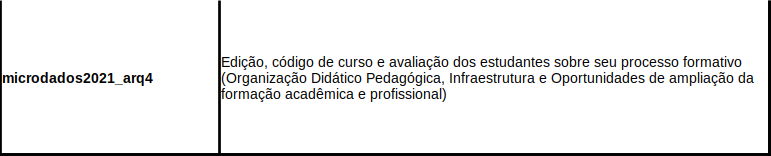

In [23]:
with open('./microdados/microdados2021_arq4.pickle', 'rb') as handle:
    dados_arq4 = data2 = pickle.load(handle)

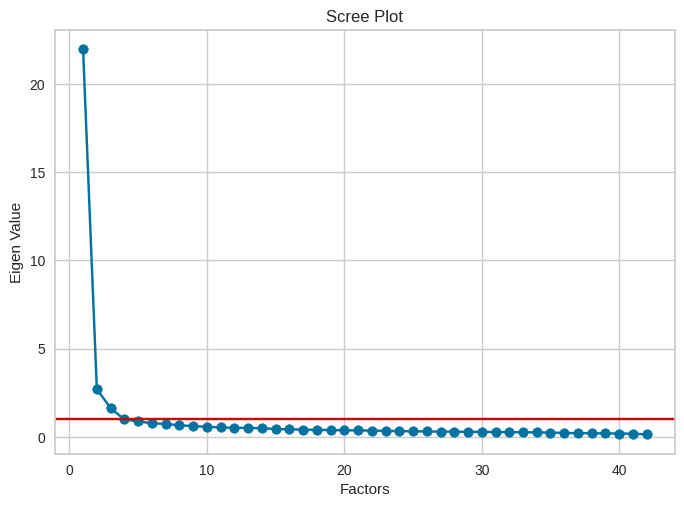

In [24]:
# Análise fatorial
from factor_analyzer.factor_analyzer import FactorAnalyzer

dataframe=dados_arq4[['QE_I27', 'QE_I28', 'QE_I29', 'QE_I30', 'QE_I31',
       'QE_I32', 'QE_I33', 'QE_I34', 'QE_I35', 'QE_I36', 'QE_I37', 'QE_I38',
       'QE_I39', 'QE_I40', 'QE_I41', 'QE_I42', 'QE_I43', 'QE_I44', 'QE_I45',
       'QE_I46', 'QE_I47', 'QE_I48', 'QE_I49', 'QE_I50', 'QE_I51', 'QE_I52',
       'QE_I53', 'QE_I54', 'QE_I55', 'QE_I56', 'QE_I57', 'QE_I58', 'QE_I59',
       'QE_I60', 'QE_I61', 'QE_I62', 'QE_I63', 'QE_I64', 'QE_I65', 'QE_I66',
       'QE_I67', 'QE_I68']]
fa = FactorAnalyzer(rotation= None,impute = "drop",n_factors=dataframe.shape[1])
fa.fit(dataframe)

# Autovalores
ev, v = fa.get_eigenvalues()

plt.scatter(range(1,dataframe.shape[1]+1),ev)
plt.plot(range(1,dataframe.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.axhline(y = 1, color = 'r', linestyle = '-')

Via screeplot temos o uso de 3 fatores/grupos de questões a serem consideradas para o redimensionamento das variaveis

In [25]:
# Análise fatorial
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(dataframe)

# Carrega os resultados em DataFrames
loadings = pd.DataFrame(fa.loadings_, index=dataframe.columns)
factor_variance = pd.DataFrame(fa.get_factor_variance(),
                               index=['Variance', 'Proportional Var', 'Cumulative Var'])

# Adiciona uma coluna para o fator dominante para cada variável
loadings['Max_Factor'] = loadings.idxmax(axis=1)

print("Cargas:")
print(tabulate(loadings, headers='keys', tablefmt='fancy_grid', numalign='center'))

print("\nVariância:")
print(tabulate(factor_variance, headers='keys', tablefmt='fancy_grid', numalign='center'))

Cargas:
╒════════╤═══════════╤══════════╤══════════╤══════════════╕
│        │     0     │    1     │    2     │  Max_Factor  │
╞════════╪═══════════╪══════════╪══════════╪══════════════╡
│ QE_I27 │ 0.738476  │ 0.156682 │ 0.241502 │      0       │
├────────┼───────────┼──────────┼──────────┼──────────────┤
│ QE_I28 │ 0.697859  │ 0.200835 │ 0.237418 │      0       │
├────────┼───────────┼──────────┼──────────┼──────────────┤
│ QE_I29 │ 0.768459  │ 0.194276 │ 0.214669 │      0       │
├────────┼───────────┼──────────┼──────────┼──────────────┤
│ QE_I30 │ 0.733991  │ 0.238367 │ 0.218704 │      0       │
├────────┼───────────┼──────────┼──────────┼──────────────┤
│ QE_I31 │ 0.792315  │ 0.161794 │ 0.199858 │      0       │
├────────┼───────────┼──────────┼──────────┼──────────────┤
│ QE_I32 │  0.58988  │ 0.264966 │ 0.164514 │      0       │
├────────┼───────────┼──────────┼──────────┼──────────────┤
│ QE_I33 │ 0.807393  │ 0.187999 │ 0.154151 │      0       │
├────────┼───────────┼──────────

É póssivel separar 3 dimensões: Nota referente à organização didáco-pedagógica (NOc), Nota referente à infraestrutura e instalações físicas (NFc) e Nota referente às oportunidades de ampliação da formação acadêmica e profissional (NAc).

## Previsão da nota geral do curso

In [26]:
data1 = data
data2['NOc'] = data2[['QE_I27', 'QE_I28', 'QE_I29', 'QE_I30', 'QE_I31',
       'QE_I32', 'QE_I33', 'QE_I34', 'QE_I35', 'QE_I36', 'QE_I37', 'QE_I38',
       'QE_I39', 'QE_I40',"QE_I42",'QE_I47','QE_I48', 'QE_I49', 'QE_I50',
                      'QE_I51', 'QE_I55', 'QE_I57','QE_I58', 'QE_I66']].mean(axis=1)

data2['NFc'] = data2[[ 'QE_I59','QE_I60', 'QE_I61', 'QE_I62', 'QE_I63',
                      'QE_I64', 'QE_I65', 'QE_I68']].mean(axis=1)

data2['NAc'] = data2[['QE_I41', 'QE_I43', 'QE_I44', 'QE_I45',
       'QE_I46','QE_I52','QE_I53','QE_I54','QE_I56','QE_I67']].mean(axis=1)


data1 = data2[["NU_ANO", "CO_CURSO",'NOc','NFc','NAc']].groupby(
    ["NU_ANO", "CO_CURSO"], as_index=False).mean().merge(data1, on=["NU_ANO","CO_CURSO"], how='left')


data1=pd.get_dummies(data1, columns=["CO_MODALIDADE","CO_CATEGAD","CO_REGIAO_CURSO"]).groupby(["NU_ANO", "CO_CURSO"], as_index=False).sum()

data1 = data1[data1['NT_GER'].notna()]
data1 = data1[data1['NOc'].notna()]
data1 = data1[data1['NFc'].notna()]
data1 = data1[data1['NAc'].notna()]

data1.head(5)

In [ ]:
# Dividir banco em treino e teste
seed = 7

def dividir_treino_teste(X, y):
    test_size = 0.33
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=test_size, random_state=seed)
    return X_treino, X_teste, y_treino, y_teste

def dividir_banco(dados):
    X = dados[['CO_MODALIDADE_0',
            'CO_MODALIDADE_1',
            'CO_CATEGAD_Especial',
            'CO_CATEGAD_Estadual',
            'CO_CATEGAD_Federal',
            'CO_CATEGAD_Municipal',
            'CO_CATEGAD_Privada com fins lucrativos',
            'CO_CATEGAD_Privada sem fins lucrativos',
            'CO_REGIAO_CURSO_Centro-Oeste',
            'CO_REGIAO_CURSO_Nordeste',
            'CO_REGIAO_CURSO_Norte',
            'CO_REGIAO_CURSO_Sudeste',
            'CO_REGIAO_CURSO_Sul','NOc','NFc','NAc']]

    y = dados[['NT_GER']]
    X_treino, X_teste, y_treino, y_teste = dividir_treino_teste(X,y)

    return X_treino, X_teste, y_treino, y_teste

In [ ]:
# Verificar ajuste e variáveis com maior peso
def verificar_ajuste(y_teste, y_predito):
    RMSE = math.sqrt(mean_squared_error(y_teste, y_predito))
    R2 = r2_score(y_teste, y_predito)

    tabela = [["RMSE", "%.5f" % RMSE], ["R2", "%.5f" % R2]]
    colunas = ["Métrica", "Valor"]

    print(tabulate(tabela, headers=colunas, tablefmt='fancy_grid'))

def calcular_importancia_variaveis(regressor, X_train, y_train, top_n=16):
    visualizacao = FeatureImportances(regressor, topn=top_n, colors=['gray'], relative=True)
    visualizacao.fit(X_train, y_train)
    visualizacao.show()

<ipython-input-21-37b5d344ade9>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X_treino, y_treino)


╒═══════════╤═════════╕
│ Métrica   │   Valor │
╞═══════════╪═════════╡
│ RMSE      │ 9.17581 │
├───────────┼─────────┤
│ R2        │ 0.48066 │
╘═══════════╧═════════╛


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


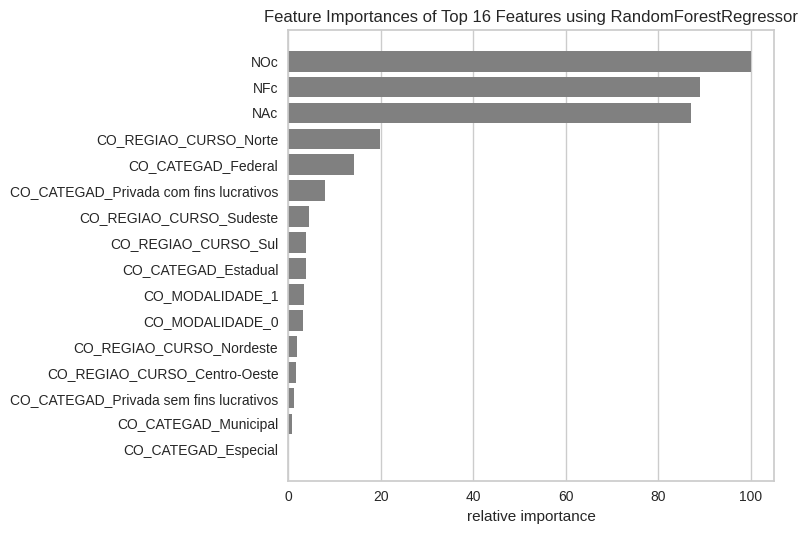

In [ ]:
X_treino, X_teste, y_treino, y_teste = dividir_banco(data1)
regressor = RandomForestRegressor(n_estimators  = 100, max_depth = 100)

regressor.fit(X_treino, y_treino)
y_preditos = regressor.predict(X_teste)

verificar_ajuste(y_teste, y_preditos)
calcular_importancia_variaveis(regressor, X_treino, y_treino)